# Active mechanisms

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl

Now, we first load the necessary modules and create a single compartment cell,

In [1]:
import neuron
from neuron import h, gui

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Single compartment cell
soma = h.Section(name="soma")
soma.L = 20
soma.diam = 20

# Add a current clamp electrode
ic = h.IClamp(soma(0.5))

Then, we insert the "hh2" mechanism (in `mod.files/HH2.mod`) and check the cells,

In [5]:
soma.insert("hh2")
soma.psection()

{'point_processes': {'IClamp': {IClamp[1]}},
 'density_mechs': {'hh2': {'gnabar': [0.003],
   'gkbar': [0.005],
   'vtraub': [-63.0],
   'm_inf': [0.0],
   'h_inf': [0.0],
   'n_inf': [0.0],
   'tau_m': [0.0],
   'tau_h': [0.0],
   'tau_n': [0.0],
   'm_exp': [0.0],
   'h_exp': [0.0],
   'n_exp': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x7fd7e0cc0060',
 'cell': None}

In [6]:
# Prepare a simulation for 300 ms,
h.tstop = 500

# Current injection of 10 pA for 200 ms
ic.delay = 50
ic.dur = 300
ic.amp = 0.005 # 5 pA

In [7]:
# We set the temperature to 35°C to simulate a mammalian neuron,
h.celsius = 35

# Record the time and voltage,
dt_rec = 0.1
t = h.Vector()
v = h.Vector()
t.record(h._ref_t, 0.1)
v.record(soma(0.5)._ref_v, dt_rec)

Vector[4]

Here, we add a `NetCon` object that will monitor the membrane potential of the cell and detect events with `v` crossing -20 mV. Since this `NetCon` does not need to deliver events to anything else, we connect it to `None`. Then, we can record the event times to a vector, which lets us to record spike times, detected by a voltage threshold.

In [ ]:
nc = h.NetCon(soma(0.5)._ref_v, None, -20, 0, 1)
tspike = h.Vector()
nc.record(tspike)

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'v (mv)')]

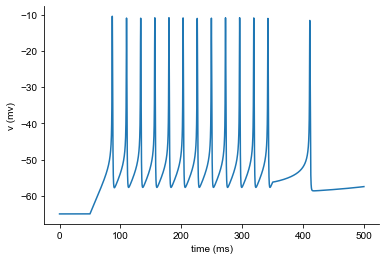

In [8]:
# Run the simulation and plot the result

h.run()

_, ax = plt.subplots()

ax.plot(t, v)
ax.set(xlabel="time (ms)", ylabel = "v (mv)")


Here We print the spike times. Note that we used `.as_numpy` to transform a NEURON `Vector` to a numpy array

In [ ]:
print(tspike.as_numpy())

## Pyramidal cell example

Now let's simulate the fully active pyramidal cell model. **Please make sure that you restart the kernel at this point.**

In [ ]:
import neuron
from neuron import h, gui
import libcell

import numpy as np
import matplotlib.pyplot as plt

First we defined a passive cell,

In [ ]:
cell = libcell.L23()

And then, we call a function in `libcell.py` to embed active mechanisms everywhere,`

In [ ]:
libcell.init_active(cell, axon=True, soma=True, dend=True, dendNa=True, dendCa=True)
cell.soma.psection()

To test the excitability of the cell, we add a current clamp electrode at soma,

In [ ]:
ic = h.IClamp(cell.soma(0.5))

Let's define a function to do a virtual current clamp experiment,

In [ ]:
def do_current_clamp(current_injected):
    
    # should not forget setting the temperature...
    h.celsius = 35
    
    # Simulation length = 300 ms
    h.tstop = 300

    # Current injection for 200 ms
    ic.delay = 50
    ic.dur = 200
    ic.amp = current_injected


    dt_rec = 0.1
    t = h.Vector()
    v = h.Vector()
    v.record(cell.soma(1)._ref_v, dt_rec)
    t.record(h._ref_t, dt_rec)

    # We set the initial voltage to -75 mV and run the simulation
    h.v_init = -75
    h.init()
    h.run()
    
    # Here we plot the result
    _, ax = plt.subplots()

    ax.plot(t, v)
    ax.set(xlabel="time (ms)", ylabel = "v (mv)")

In [ ]:
do_current_clamp(0.1) # 100 pA injection; the cell is still in a subthreshold regime

In [ ]:
do_current_clamp(0.35) # 350 pA injection will give you spikes

### Adding synapses

Here we will add some synapses to the cell. These functions are copied from `libcell.py` and modified to connect each synapse to external artificial spike generators.

In [ ]:
def add_AMPAsyns(model, locs, stims, gmax=1, tau1=0.5, tau2=1):
    """inserts AMPA synapses into model at locs and connect them to stims.
    locs is a list of lists containing two numbers, such as [[0, 0.5]]. The first
    number denotes which dendritic compartement the synapse will be located
    and the second is a relative coordinate. For example, [[0, 0.5]] will embed
    one synapse at model.dends[0](0.5). gmax is a maximal conductance in uS.
    tau1 and tau2 are a rising and decay time constant in ms.
    """
    # we store synapses and NetCons in a list
    model.AMPAlist = []
    model.ncAMPAlist = []
    
    # set in nS and convert to muS
    gmax = gmax/1000.
    
    for loc, stim in zip(locs, stims):
        # an AMPA synapse is `Exp2Syn` with a reversal potential = 0 mV
        AMPA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])])
        AMPA.tau1 = tau1
        AMPA.tau2 = tau2
        
        # connect stim to the synapse
        NC = h.NetCon(stim, AMPA, 0, 0, gmax)
        model.AMPAlist.append(AMPA)
        model.ncAMPAlist.append(NC)

In [ ]:
def add_NMDAsyns(model, locs, stims, gmax=1, tau1=2, tau2=20):
    """inserts NMDA synapses into model at locs and connect them to stims."""
    model.NMDAlist = []
    model.ncNMDAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc, stim in zip(locs, stims):
        # an NMDA synapse
        NMDA = h.Exp2SynNMDA(float(loc[1]), sec=model.dends[int(loc[0])])
        NMDA.tau1 = tau1
        NMDA.tau2 = tau2
        NC = h.NetCon(stim, NMDA, 0, 0, gmax)
        x = float(loc[1])
        model.NMDAlist.append(NMDA)
        model.ncNMDAlist.append(NC)

In [ ]:
def add_GABAsyns(model, locs, stims, gmax=0.5, tau1=0.1, tau2=4, rev=-80):
    """insetrs GABA synapses into model at locs and connect them to stims."""
    model.GABAlist = []
    model.ncGABAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc, stim in zip(locs, stims):
        # a GABA synapse is `Exp2Syn` with a reversal potential = rev mV 
        # (default value = -80 mV)
        GABA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])])
        GABA.tau1 = tau1
        GABA.tau2 = tau2
        GABA.e = rev
        NC = h.NetCon(stim, GABA, 0, 0, gmax)
        model.GABAlist.append(GABA)
        model.ncGABAlist.append(NC)

Lets add an AMPA+NMDA synapse at cell.dend\[0\](0.5) and connect it to an artificial spike generator.

In [ ]:
# location = cell.dend[0](0.5)
locs = [[0, 0.5]]

# spiking frequency = 10 Hz, ISI = 1000/10 = 100 ms
fexc = 10

exc_stims = []
for loc in locs:
    exc_stims.append(h.NetStimFD()) # An articifial spike generator
    exc_stims[-1].noise = 0 # no noise
    exc_stims[-1].start = 150 # start from 150 ms
    exc_stims[-1].duration = h.tstop
    exc_stims[-1].interval = 1000./fexc # set ISI

# Add an AMPA synapse connected to exc_stims
add_AMPAsyns(cell, locs, exc_stims)
# Add an NMDA synapse at the same location, also connected to exc_stims
add_NMDAsyns(cell, locs, exc_stims)


In [ ]:
do_current_clamp(0.0) # Run a simulation with no current injection

Now let's try many more synapses, inserted at random locations! We first make a function to create random locations in the cell's dendrites.

In [ ]:
def genRandomLocs(model, nsyn):
    """generates nsyn random locations distributed in model.dends."""
    locs = []
    for s in np.arange(0,nsyn):
        dend = np.random.randint(low=0, high=len(model.dends))
        pos = np.random.uniform()
        locs.append([dend, pos])
    return locs

And then, we create 100 excitatory and 20 inhibitory synapse locations.

In [ ]:
n_exc = 100
n_inh = 20

exc_locs = genRandomLocs(cell, n_exc)
inh_locs = genRandomLocs(cell, n_inh)
inh_locs

We connect the excitatory synapses to spike generators, Poisson firing at 10 Hz. The inhibitory ones will be connected to another set of spike generators firing at 40 Hz.

In [ ]:
# excitatory stims
fexc = 10 # 10 Hz
exc_stims = []
for loc in exc_locs:
    exc_stims.append(h.NetStimFD())
    exc_stims[-1].noise = 1 # maximally noisy stimulus
    exc_stims[-1].start = 0 # start from 0
    exc_stims[-1].duration = h.tstop
    exc_stims[-1].interval = 1000./fexc

add_AMPAsyns(cell, exc_locs, exc_stims)
add_NMDAsyns(cell, exc_locs, exc_stims)


# inhibitory stims
finh = 40 # 40 Hz
inh_stims = []
for loc in inh_locs:
    inh_stims.append(h.NetStimFD())
    inh_stims[-1].noise = 1 # maximally noisy stimulus
    inh_stims[-1].start = 0 # start from 0
    inh_stims[-1].duration = h.tstop
    inh_stims[-1].interval = 1000./fexc

add_GABAsyns(cell, inh_locs, inh_stims)

In [ ]:
do_current_clamp(-0.1) # Run a simulation with no current injection